# ES-Bi-LSTM model 



In [3]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict, deque
from IPython.display import Image

from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error #mean_absolute_percentage_error
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [4]:
#data crime all loc/nozero','energyall.csv

Load data into Pandas dataframe

In [5]:
filee='allgood'

In [6]:
energy1 = load_data('D:/dataset type of crime new/new no wrong/',filee+'.csv')
energy1.head()

,Unnamed: 0,load,crime1,crime2,crime3,crime4,crime5
2006-01-01 00:00:00,0,161,19,26,15,45,56
2006-01-01 01:00:00,1,72,21,9,16,15,11
2006-01-01 02:00:00,2,54,13,6,15,10,10
2006-01-01 03:00:00,3,47,9,7,18,9,4
2006-01-01 04:00:00,4,52,7,10,20,12,3


In [7]:
year0=2010
year=str(year0)
year3=str(year0+3)
year2=str(year0+4)
energy = energy1.copy()[energy1.index >= year+'-01-1 00:00:00' ]

In [8]:
energy

,Unnamed: 0,load,crime1,crime2,crime3,crime4,crime5
2010-01-01 00:00:00,35064,256,12,14,16,180,34
2010-01-01 01:00:00,35065,81,13,8,20,26,14
2010-01-01 02:00:00,35066,59,7,12,28,5,7
2010-01-01 03:00:00,35067,63,9,6,29,14,5
2010-01-01 04:00:00,35068,67,5,13,28,18,3
...,...,...,...,...,...,...,...
2019-12-31 19:00:00,122707,27,9,6,1,6,5
2019-12-31 20:00:00,122708,39,9,12,9,6,3
2019-12-31 21:00:00,122709,28,5,4,8,5,6
2019-12-31 22:00:00,122710,40,12,7,7,3,11


## Data preparation

For this example, we will set *T=6*. This means that the input for each sample is a vector of the prevous 6 hours of the number of crime. The choice of *T=6* was arbitrary but should be selected through experimentation.

*HORIZON=3* specifies that we have a forecasting horizon of 3 (*t+3*)

In [9]:
valid_start_dt = year3+'-08-29 23:11:00'
test_start_dt = year2+'-01-01 11:00:00'
test_end_dt = year2+'-12-30 18:00:00'

T = 6
HORIZON = 1

In [10]:
LATENT_DIM = 5 # number of units in the RNN layer
BATCH_SIZE = 48 # number of samples per mini-batch
EPOCHS = 10 # maximum number of times the training algorithm will cycle through all samples
m = 24 # seasonality length

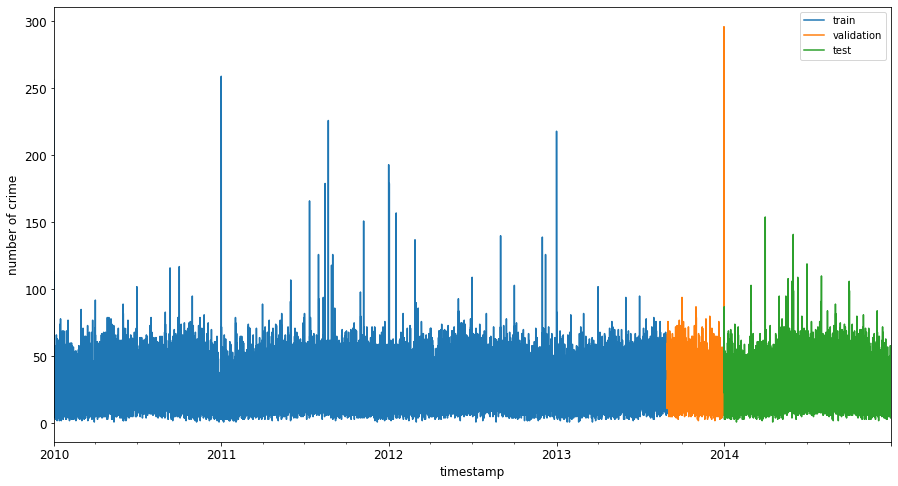

In [11]:
energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'train'}) \
    .join(energy[(energy.index >=valid_start_dt) & (energy.index < test_start_dt)][['load']] \
          .rename(columns={'load':'validation'}), how='outer') \
    .join(energy[test_start_dt:test_end_dt][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('number of crime', fontsize=12)
plt.show()

In [12]:
energy11=energy.copy()
energy12=energy.copy()

In [13]:
train = energy.copy()[energy.index < valid_start_dt][['load']]

In [14]:
train

,load
2010-01-01 00:00:00,256
2010-01-01 01:00:00,81
2010-01-01 02:00:00,59
2010-01-01 03:00:00,63
2010-01-01 04:00:00,67
...,...
2013-08-29 19:00:00,35
2013-08-29 20:00:00,49
2013-08-29 21:00:00,39
2013-08-29 22:00:00,40


In [15]:
train

,load
2010-01-01 00:00:00,256
2010-01-01 01:00:00,81
2010-01-01 02:00:00,59
2010-01-01 03:00:00,63
2010-01-01 04:00:00,67
...,...
2013-08-29 19:00:00,35
2013-08-29 20:00:00,49
2013-08-29 21:00:00,39
2013-08-29 22:00:00,40


Create training set.

In [16]:
train = energy.copy()[energy.index < valid_start_dt][['load']]

Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

In [17]:
train

,load
2010-01-01 00:00:00,256
2010-01-01 01:00:00,81
2010-01-01 02:00:00,59
2010-01-01 03:00:00,63
2010-01-01 04:00:00,67
...,...
2013-08-29 19:00:00,35
2013-08-29 20:00:00,49
2013-08-29 21:00:00,39
2013-08-29 22:00:00,40


In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train[['load']])
train[['load']] = scaler.transform(train)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [19]:
tensor_structure = {'X':(range(-T+1, 1), ['load'])}
print(tensor_structure)
train_inputs = TimeSeriesTensor(train, 'load', HORIZON,BATCH_SIZE, tensor_structure)
len(train_inputs['X'])

{'X': (range(-5, 1), ['load'])}


32064

In [20]:
train_inputs.dataframe.head(3)

tensor              target    X                         
feature                  y load                         
time step              t+1  t-5  t-4  t-3  t-2  t-1    t
2010-01-01 05:00:00   0.10 0.99 0.31 0.22 0.24 0.26 0.14
2010-01-01 06:00:00   0.11 0.31 0.22 0.24 0.26 0.14 0.10
2010-01-01 07:00:00   0.19 0.22 0.24 0.26 0.14 0.10 0.11

In [21]:
print("y_train shape: ", train_inputs['target'].shape)
print("x_train shape: ", train_inputs['X'].shape)

y_train shape:  (32064, 1)
x_train shape:  (32064, 6, 1)


In [22]:
train_inputs['X'][:3]

array([[[0.99],
        [0.31],
        [0.22],
        [0.24],
        [0.26],
        [0.14]],

       [[0.31],
        [0.22],
        [0.24],
        [0.26],
        [0.14],
        [0.1 ]],

       [[0.22],
        [0.24],
        [0.26],
        [0.14],
        [0.1 ],
        [0.11]]])

In [23]:
train_inputs['target'][:3]

feature,y
time step,t+1
2010-01-01 05:00:00,0.10
2010-01-01 06:00:00,0.11
2010-01-01 07:00:00,0.19


Construct validation set (keeping T hours from the training set in order to construct initial features)

In [24]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load']]
valid[['load']] = scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, 'load', HORIZON,BATCH_SIZE, tensor_structure)

In [25]:
valid #2,976

,load
2013-08-29 19:00:00,0.13
2013-08-29 20:00:00,0.19
2013-08-29 21:00:00,0.15
2013-08-29 22:00:00,0.15
2013-08-29 23:00:00,0.16
...,...
2014-01-01 06:00:00,0.12
2014-01-01 07:00:00,0.12
2014-01-01 08:00:00,0.17
2014-01-01 09:00:00,0.17


## Implement ES-RNN

We will implement ES-RNN forecasting model with the following structure:

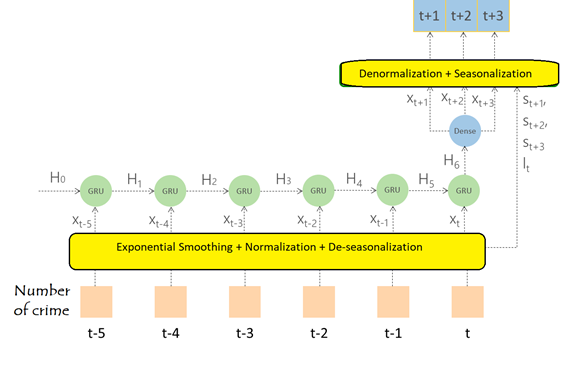

In [26]:
Image('./images/Untitled.png')

In [27]:
from keras.models import Model
from keras.layers import Input, GRU, Dense, Lambda,LSTM,Dropout,Bidirectional,TimeDistributed,RepeatVector,Flatten,merge
from keras.callbacks import EarlyStopping
from keras.models import Sequential

Using TensorFlow backend.


### Create custom layers in Keras
In this section we define two custom layers:
- ***ES*** layer: This layer implements the Expomemtial Smoothing,  normalization and de-seasonalization for input data.
- ***Denormalization*** layer: This layer takes the normalization and de-seasonalization coefficients from ES layer and multiply them to output of RNN for de-normalization and seasonalization.


There are 3 methods you need to implement in your custom layer:
- build(input_shape): this is where you will define your weights.
- call(x): this is where the layer's logic lives.
- compute_output_shape(input_shape): in case your layer modifies the shape of its input, you should specify here the shape transformation logic. 

You can check [Keras documentation](https://keras.io/layers/writing-your-own-keras-layers/) for more details about creating custom layer.

In [28]:
from keras import backend as K
from keras.layers import Layer
from keras import initializers

# Exponential Smoothing + Normalization
class ES(Layer):

    def __init__(self, horizon, m, batch_size, time_steps, **kwargs):
        self.horizon = horizon
        self.m = m
        self.batch_size = batch_size
        self.time_steps = time_steps
        
        super(ES, self).__init__(**kwargs)

    # initialization of the learned parameters of exponential smoothing
    def build(self, input_shape):
        self.alpha = self.add_weight(name='alpha', shape=(1,),
                                     initializer='uniform', trainable=True)
        print(self.alpha )
        self.gamma = self.add_weight(name='gamma', shape=(1,),
                                     initializer='uniform', trainable=True)
        self.bata = self.add_weight(name='bata', shape=(1,),
                                     initializer='uniform', trainable=True)
        self.init_seasonality = self.add_weight(name='init_seasonality', shape=(self.m,),
                                                initializer=initializers.Constant(value=0.8), trainable=True)
        print(self.init_seasonality)
        self.init_seasonality_list = [K.slice(self.init_seasonality,(i,),(1,)) for i in range(self.m)]
        self.seasonality_queue = deque(self.init_seasonality_list, self.m)
        #print(self.seasonality_queue)
        self.level = self.add_weight(name='init_level', shape=(1,),
                                     initializer=initializers.Constant(value=0.8), 
                                     trainable=True)
        self.bevel = self.add_weight(name='init_bevel', shape=(1,),
                                     initializer=initializers.Constant(value=0.8), 
                                     trainable=True)
        super(ES, self).build(input_shape)  

    def call(self, x):

        # extract time-series from feature vector
        n_examples = K.int_shape(x)[0]
        if n_examples is None:
            n_examples = self.batch_size
        x1 = K.slice(x,(0,0,0),(1,self.time_steps,1))
        x1 = K.reshape(x1,(self.time_steps,))
        #print(x1)
        x2 = K.slice(x,(1,self.time_steps-1,0),(n_examples-1,1,1))
        x2 = K.reshape(x2,(n_examples-1,))
        #print(x2)
        ts = K.concatenate([x1,x2])
        #print(ts)
        
        x_norm = []  # normalized values of time-series
        ls = []      # coeffients for denormalization of forecasts
        
        l_t_minus_1 = self.level
        b_t_minus_1=self.bevel
        print(n_examples+self.time_steps-1)
        for i in range(n_examples+self.time_steps-1):
        
            # compute l_t
            y_t = ts[i]
            s_t = self.seasonality_queue.popleft()
            l_t = self.alpha * y_t / s_t + (1 - self.alpha) * (l_t_minus_1+b_t_minus_1)
            b_t=self.bata *(l_t-l_t_minus_1)+(1-self.bata)*b_t_minus_1
            # compute s_{t+m}
            s_t_plus_m = self.gamma * y_t / (l_t+b_t) + (1 - self.gamma) * s_t
            
            self.seasonality_queue.append(s_t_plus_m)
          
            # normalize y_t
            x_norm.append(y_t / (s_t * l_t))

            l_t_minus_1 = l_t

            if i >= self.time_steps-1:
                l = [l_t]*self.horizon
                l = K.concatenate(l)
                s = [self.seasonality_queue[i] for i in range(self.horizon)] # we assume here that horizon < m
                s = K.concatenate(s)
                ls_t = K.concatenate([K.expand_dims(l), K.expand_dims(s)])
                ls.append(K.expand_dims(ls_t,axis=0))  
       
        self.level = l_t
        self.bevel = b_t
        x_norm = K.concatenate(x_norm)

        # create x_out
        x_out = []
        for i in range(n_examples):
            norm_features = K.slice(x_norm,(i,),(self.time_steps,))
            norm_features = K.expand_dims(norm_features,axis=0)
            x_out.append(norm_features)

        x_out = K.concatenate(x_out, axis=0)
        x_out = K.expand_dims(x_out)

        # create tensor of denormalization coefficients 
        denorm_coeff = K.concatenate(ls, axis=0)
        return [x_out, denorm_coeff]

    def compute_output_shape(self, input_shape):
        return [(input_shape[0], input_shape[1], input_shape[2]), (input_shape[0], self.horizon, 2)]
    
class Denormalization(Layer):
    
    def __init__(self, **kwargs):
        super(Denormalization, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Denormalization, self).build(input_shape)  

    def call(self, x):
        print(x[1].shape)
        return x[0] *( x[1][:,:,0] * x[1][:,:,1])

    def compute_output_shape(self, input_shape):
        return input_shape[0]

### Create ES-RNN model
Since Denormalization layer has inputs from two previous layers, we need to use functional API of Keras to create the model.

In [29]:
model_input = Input(shape=(None, 1))
[normalized_input, denormalization_coeff] = ES(HORIZON, m, BATCH_SIZE, T)(model_input)

#gru_out =Bidirectional( LSTM(LATENT_DIM))(normalized_input)
gru_out =Bidirectional( LSTM(LATENT_DIM,activation='tanh'))(normalized_input)
model_output_normalized = Dense(HORIZON)(gru_out)
model_output = Denormalization()([model_output_normalized, denormalization_coeff])
model = Model(inputs=model_input, outputs=model_output)

<tf.Variable 'es_1/alpha:0' shape=(1,) dtype=float32_ref>
<tf.Variable 'es_1/init_seasonality:0' shape=(24,) dtype=float32_ref>
53
(48, 1, 2)


In [29]:
model.compile(optimizer='RMSprop', loss='mse')

In [30]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
es_1 (ES)                       [(None, None, 1), (N 29          input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 10)           280         es_1[0][0]                       
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            11          bidirectional_1[0][0]            
__________________________________________________________________________________________________
denormaliz

In [31]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='./images/model_plot.png', show_shapes=True, show_layer_names=True)

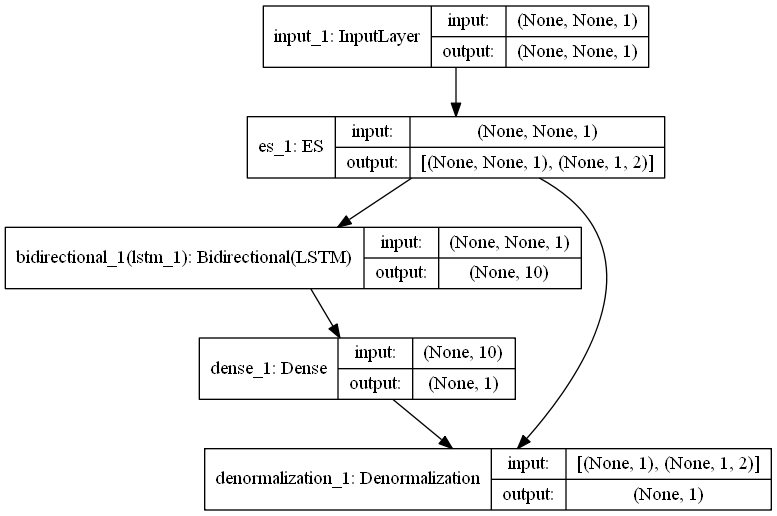

In [32]:
Image('./images/model_plot.png')

In [33]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20)

In [34]:
model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          shuffle=False,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop],
          verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 32064 samples, validate on 2976 samples
Epoch 1/10





32064/32064 [==============================] - 9s 283us/step - loss: 0.0131 - val_loss: 0.0173
Epoch 2/10
32064/32064 [==============================] - 5s 155us/step - loss: 0.0088 - val_loss: 0.0242
Epoch 3/10
32064/32064 [==============================] - 6s 178us/step - loss: 0.0084 - val_loss: 0.0276
Epoch 4/10
32064/32064 [==============================] - 5s 163us/step - loss: 0.0084 - val_loss: 0.0287
Epoch 5/10
32064/32064 [==============================] - 5s 158us/step - loss: 0.0084 - val_loss: 0.0293
Epoch 6/10
32064/32064 [==============================] - 5s 171us/step - loss: 0.0083 - val_loss: 0.0295TA
Epoch 7/10
32064/32064 [==============================] - 5s 166us/step - loss: 0.0083 - val_loss: 0.0297
Epoch 8/10
32064/32064 [==============================] - 5s 161us/step - loss: 0.0083 - val_loss: 0.0298

In [34]:
#model.save_weights("es_bi_lstm_"+filee+".h5")

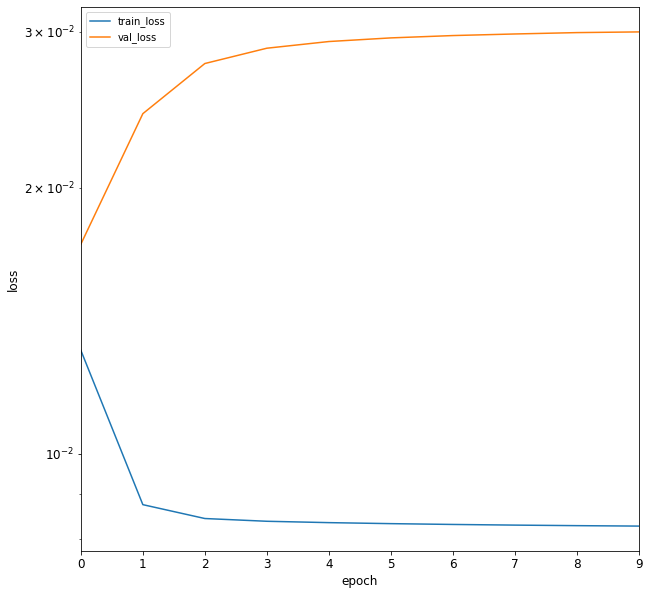

In [35]:
plot_df = pd.DataFrame.from_dict({'train_loss':model.history.history['loss'], 'val_loss':model.history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

## Evaluate the model

In [36]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:test_end_dt][['load']]
test[['load']] = scaler.transform(test)
test_inputs = TimeSeriesTensor(test, 'load', HORIZON,BATCH_SIZE, tensor_structure)

In [37]:
predictions = model.predict(test_inputs['X'], batch_size=BATCH_SIZE)


In [38]:
predictions

array([[0.13],
       [0.23],
       [0.41],
       ...,
       [0.15],
       [0.15],
       [0.13]], dtype=float32)

In [39]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, scaler,BATCH_SIZE)
eval_T1=eval_df[eval_df['h']=='t+1']
eval_T2=eval_df[eval_df['h']=='t+2']
eval_T3=eval_df[eval_df['h']=='t+3']

Compute MAPE for each forecast horizon

In [40]:
mapa1=mean_absolute_percentage_error(eval_T1['prediction'], eval_T1['actual'])
print(mapa1)

0.9529901535576542


In [41]:
mean_squared_error(eval_T1['prediction'], eval_T1['actual'], squared=False)

9.71371320747756

In [42]:
mean_absolute_error(eval_T1['prediction'], eval_T1['actual'])

8.507399677892403

# _________________________________________
****************************************

In [43]:
mape(eval_df['prediction'], eval_df['actual'])

inf

In [44]:
np.sqrt((eval_df['prediction'] - eval_df['actual']) ** 2).mean()

8.507399677892403

In [45]:
((eval_df['prediction'] - eval_df['actual']).abs()).mean()

8.507399677892403

Compute MAPE across all predictions

In [46]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1   inf
Name: APE, dtype: float64

Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

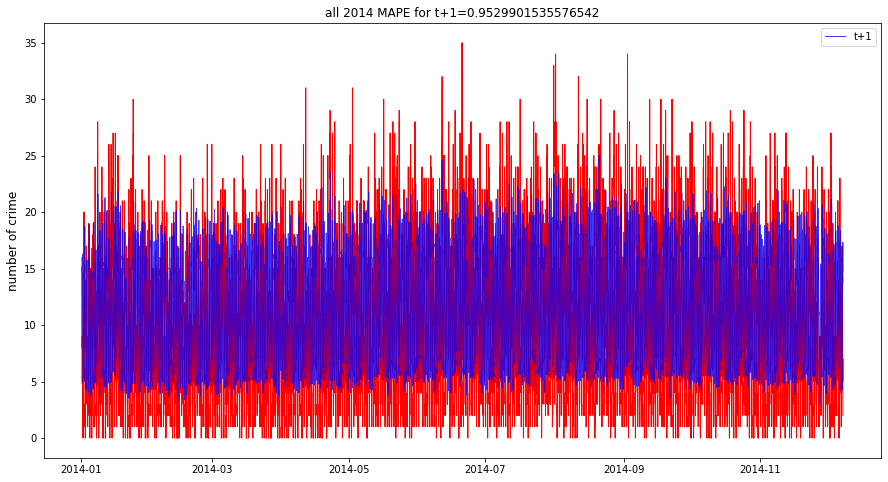

In [48]:
plot_df = eval_df[(eval_df.timestamp<year2+'-12-08') & (eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[(eval_df.timestamp<year2+'-12-08') & (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=1.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=1.0, alpha=0.75,label='t+1')

plt.ylabel('number of crime', fontsize=12)
try:
    arr=energy['BORO_NM'].unique()[0]
except KeyError:
    
    arr="all"

       
plt.title(arr+" "+year2+" MAPE for t+1="+str(mapa1))
ax.legend(loc='best')
plt.show()

In [48]:
print(plot_df['actual'].sum())
print(int(plot_df['t+1'].sum()))


4555.0
4453


In [60]:
path1="C:/Users/ghazwan/Pictures/last test/"+str(year2)+"/hourly/all/"
model.save_weights(path1+"es_bi_lstm_all_"+year2+".h5")
model.save(path1+"es_bi_lstm_all_2"+year2)
eval_T1.to_csv (path1+"es_bi_lstm_all_"+year2+'XL.csv')

In [46]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error